<a href="https://colab.research.google.com/github/YRYoung/HPC/blob/main/Assigenment/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import timeit

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from numba import jit
from scipy.signal import convolve2d
from scipy.sparse import coo_matrix
from petsc4py import PETSc
from scipy.sparse.linalg import spsolve
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
!pip install petsc4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 4.5 MB/s 
     |████████████████████████████████| 18.4 MB 89.6 MB/s 
     |████████████████████████████████| 2.5 MB 61.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Failed building wheel for petsc4py
  Running setup.py clean for petsc4py
  ERROR: Failed building wheel for petsc
  Running setup.py clean for petsc
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438427 sha256=540b13dd2e3d8e6f2942dca00c3cd93fb9e21ef97592190ced2cb06337097162
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py
Failed to build petsc4py petsc
    Running setup.py install for petsc ... done
  DEPRECATION: petsc was installed using the legacy 'setup.py install

In [4]:
k = 5


def generate_A(N):
    size = (N - 1) ** 2
    nnz = ((N - 2) * 3 + 1) ** 2

    @jit(nopython=True)
    def get_A_numba():
        row = np.zeros(nnz, dtype=np.int32)
        col = np.zeros(nnz, dtype=np.int32)
        data = np.zeros(nnz)

        h = 1 / N
        const = h ** 2 * k ** 2
        v1 = (24 - 4 * const) / 9
        v2 = (-3 - const) / 9
        v3 = (-12 - const) / 36

        count = 0
        for i in range(size):
            for j in range(i, size):
                if i == j:
                    row[count] = i
                    col[count] = j
                    data[count] = v1
                    count += 1
                elif (i == j - 1 and j % (N - 1) != 0) or j - i == N - 1:
                    row[count:count + 2] = [i, j]
                    col[count:count + 2] = [j, i]
                    data[count:count + 2] = [v2, v2]
                    count += 2
                elif (j - i == N and j % (N - 1) != 0) or (j - i == N - 2 and i % (N - 1) != 0):
                    row[count:count + 2] = [i, j]
                    col[count:count + 2] = [j, i]
                    data[count:count + 2] = [v3, v3]
                    count += 2
        return data, (row, col)

    A = coo_matrix(get_A_numba(), shape=(size, size)).tocsr()
    return A




def generate_b(N):
    h = 1 / N
    const = h ** 2 * k ** 2
    const1 = (12 + const) / 36
    const2 = (3 + const) / 9

    window = np.array([[const1, const2, const1],
                       [const2, 0, const2],
                       [const1, const2, const1]])
    x = np.linspace(0, 1, N + 1)
    X, Y = np.meshgrid(x, x)
    X[1:N, 1:N] = 0
    Y[1:N, 1:N] = 0
    Z = np.sin(3 * X + 4 * Y)
    return convolve2d(Z, window, mode='valid').flatten()

## Part 2

* solve the matrix-vector problem for $N=4$, $N=8$, and $N=16$

* plot the approximate solutions to the Helmholtz problem.

In [7]:
def get_uh(u):
    window = np.array([[1, 1], [1, 1]]) / 4
    return convolve2d(u, window, mode='full', boundary='symm')


def solve_x(N):
    A = generate_A(N)
    b = generate_b(N)
    u = spsolve(A, b).reshape((N - 1, N - 1))
    return get_uh(u)

  0%|          | 0/5 [00:00<?, ?it/s]

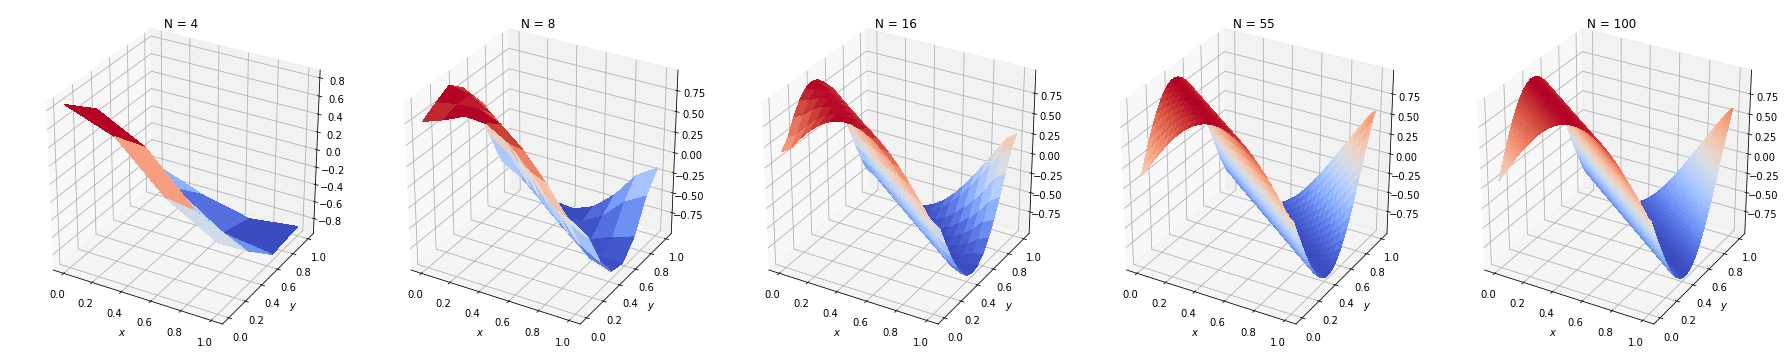

In [8]:
Ns = [4, 8, 16, 55, 100]


def plot():
    fig = plt.figure(figsize=(5 * len(Ns), 5))

    for i, N in enumerate(tqdm(Ns)):
        u = solve_x(N)

        ticksX = ticksY = np.linspace(0, 1, N )
        X, Y = np.meshgrid(ticksX, ticksY)

        ax = fig.add_subplot(1, len(Ns), i + 1, projection='3d')
        ax.plot_surface(X, Y, u, antialiased=False, cmap=cm.coolwarm)
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_title(r'N = {}'.format(N))

    fig.tight_layout(h_pad=4)
    plt.show()


plot()

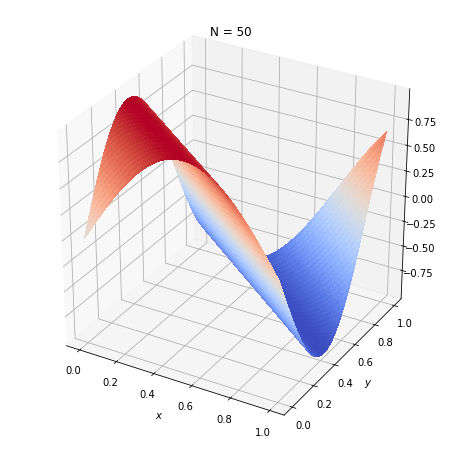

In [9]:
def plot_trueU(N):
    x = np.linspace(0, 1, N )
    X, Y = np.meshgrid(x, x)
    Z = np.sin(3 * X + 4 * Y)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z, antialiased=False, cmap=cm.coolwarm)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(r'N = {}'.format(N))

plot_trueU(50)


## Part 3

* solve the matrix-vector problem with small to medium-sized value of $N$ using a range of different solvers of your choice

    * at least **5** matrix-vector solvers:
        * at least **2** of these should be **iterative** solvers, at least **1** should be a **direct** solver.
        * use some solvers from the Scipy library and some from **PETSc**.

* measuring factors you deem to be important for your evaluation.

    * factors should include the **time** taken by the solver,

        * may additionally include many other things, such as:

          1. the number of **iterations**
          2. the size of the **residual** after each iteration


* Make a set of plots that show the measurements you have made and allow you to compare the solvers.



In [10]:
def get_true_u(N):
    def g(x, y):
        return np.sin(3 * x + 4 * y)

    x = np.linspace(0, 1, N)
    X, Y = np.meshgrid(x, x)
    Z = g(X, Y)

    return Z


def calculate_error(u, N):
    error = np.sum(abs(get_uh(u) - get_true_u(N))) / (N ** 2)
    return error

In [11]:
class Solver:
    def __init__(self, name: str):
        self.name = name
        self.times = []
        self.solutions = []
        self.PC = 'none'
        self.residuals = []
        self.iterations = []
        self.errors = []

    def solve(self, AA, bb, count_time=True, save_residuals=True, save_iterations=True, save_solutions=False,
              save_errors=False):
        ksp = PETSc.KSP().create()
        ksp.setOperators(AA)

        x = AA.createVecRight()

        ksp.setType(self.name)
        ksp.getPC().setType(self.PC)
        ksp.setConvergenceHistory()

        if count_time:
            self.times += [timeit.Timer(lambda: ksp.solve(bb, x)).timeit(1)]
        else:
            ksp.solve(bb, x)
        if save_residuals:
            self.residuals += [ksp.getConvergenceHistory()]
        if save_iterations:
            self.iterations += [ksp.getIterationNumber()]
        if save_solutions:
            self.solutions += [x.array.reshape((N - 1, N - 1))]
            if save_errors:
                self.errors += [calculate_error(self.solutions[-1], N)]


def prepare_PET_data(A, b):
    AA = PETSc.Mat()
    AA.createAIJWithArrays(A.shape, (A.indptr, A.indices, A.data))
    bb = AA.createVecLeft()
    bb.array[:] = b
    return AA, bb


def iterate_pet_solvers(solvers, A, b):
    AA, bb = prepare_PET_data(A, b)

    for pet_solver in solvers:
        pet_solver.solve(AA, bb)

  0%|          | 0/10 [00:00<?, ?it/s]

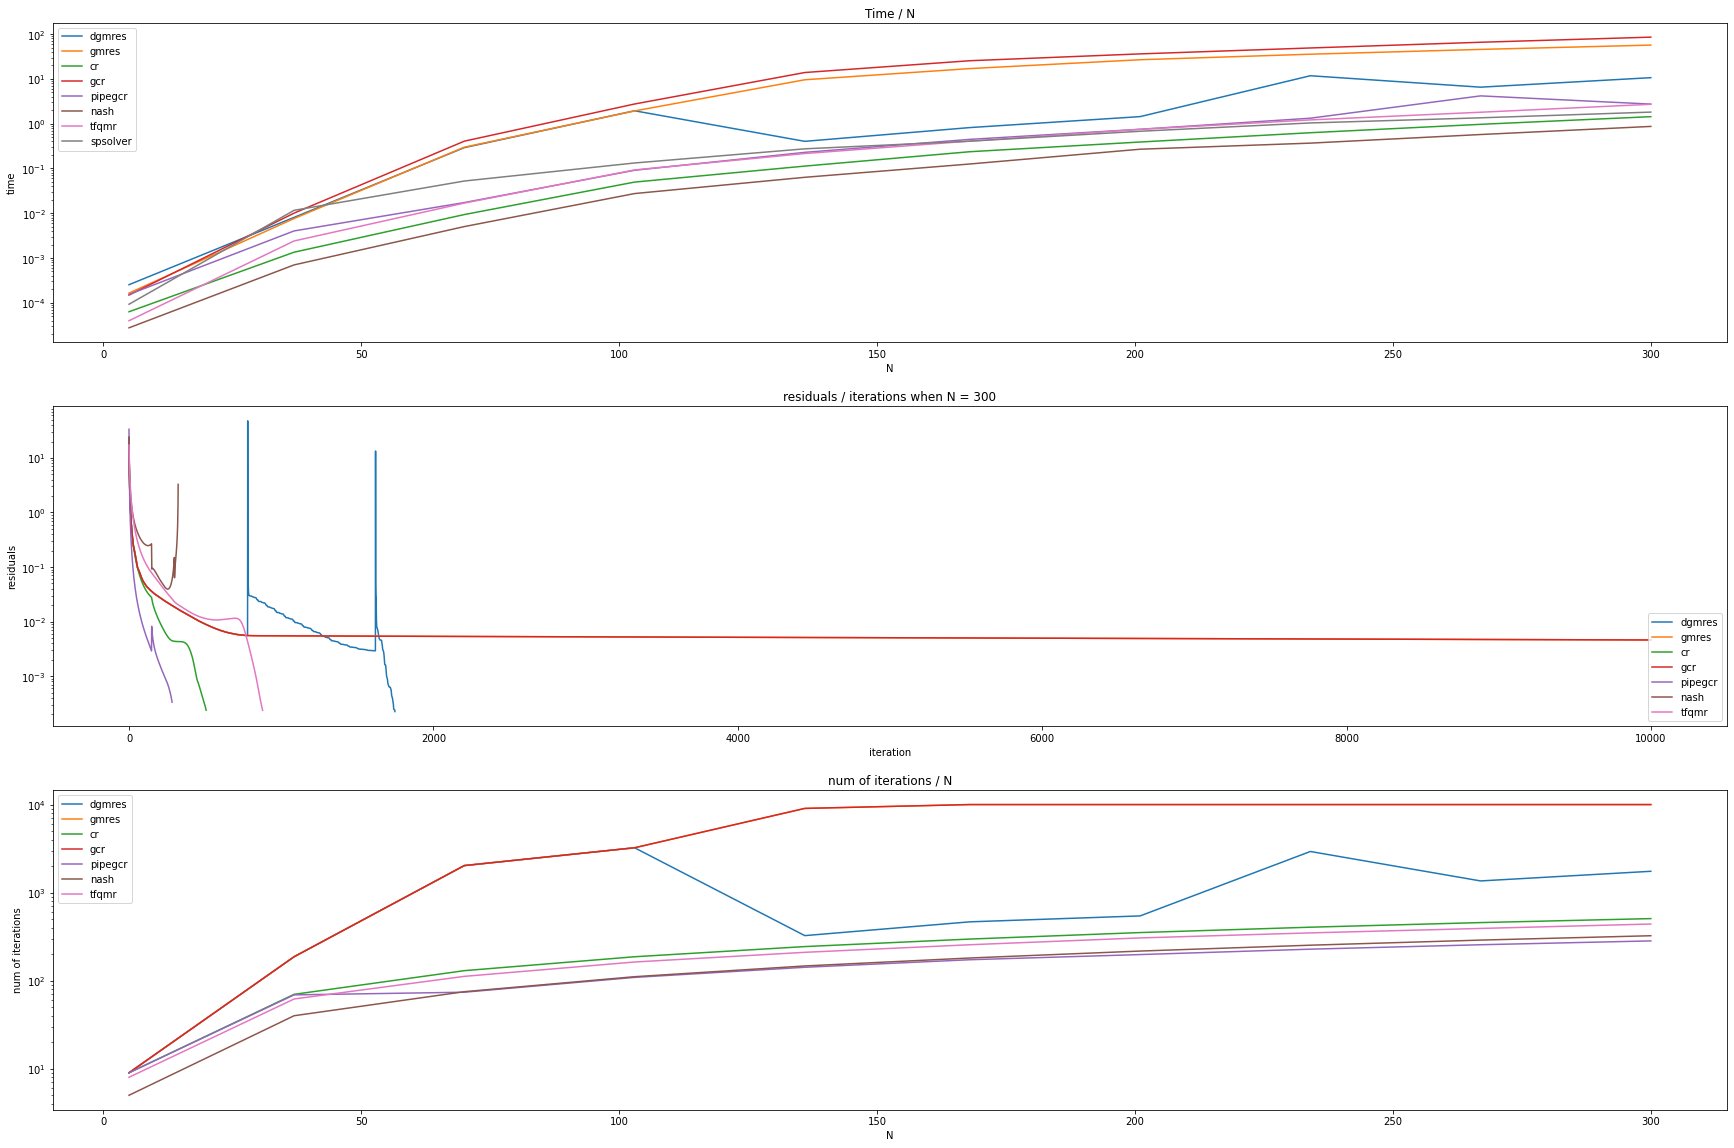

In [12]:
Ns = np.linspace(5, 300, 10, dtype=np.int32)


def test_solvers():
    PET_solvers = [Solver(name) for name in ['dgmres', 'gmres', 'cr', 'gcr', 'pipegcr', 'nash', 'tfqmr']]
    sp = Solver('spsolver')
    for N in tqdm(Ns):
        A = generate_A(N)
        b = generate_b(N)

        sp.solutions += [spsolve(A, b)]
        sp.times += [timeit.Timer(lambda: spsolve(A, b)).timeit(1)]

        iterate_pet_solvers(PET_solvers, A, b)

    PET_solvers.append(sp)

    fig = plt.figure(figsize=(30, 20))

    plt.subplot(3, 1, 1)
    ps = []
    for i, sv in enumerate(PET_solvers):
        p0, = plt.semilogy(Ns, sv.times)
        ps += [p0]

    plt.legend(ps, [sv.name for sv in PET_solvers], loc='upper left')
    plt.title('Time / N')
    plt.ylabel('time')
    plt.xlabel('N')

    plt.subplot(3, 1, 2)
    ps = []
    for i, sv in enumerate(PET_solvers):
        if i == len(PET_solvers) - 1: continue

        p0, = plt.semilogy(sv.residuals[-1])
        ps += [p0]
    plt.legend(ps, [sv.name for sv in PET_solvers], loc='lower right')
    plt.title('residuals / iterations when N = {}'.format(Ns[-1]))
    plt.ylabel("residuals")
    plt.xlabel('iteration')

    plt.subplot(3, 1, 3)
    ps = []
    for i, sv in enumerate(PET_solvers):
        if i == len(PET_solvers) - 1: continue

        p0, = plt.semilogy(Ns, sv.iterations)
        ps += [p0]
    plt.legend(ps, [sv.name for sv in PET_solvers], loc='upper left')
    plt.title('num of iterations / N')
    plt.ylabel("num of iterations")
    plt.xlabel('N')

    plt.show()


test_solvers()


* For **2** of the iterative solvers you have chosen to use, repeat the comparisons with **3** different choices of **preconditioner**.

  0%|          | 0/10 [00:00<?, ?it/s]

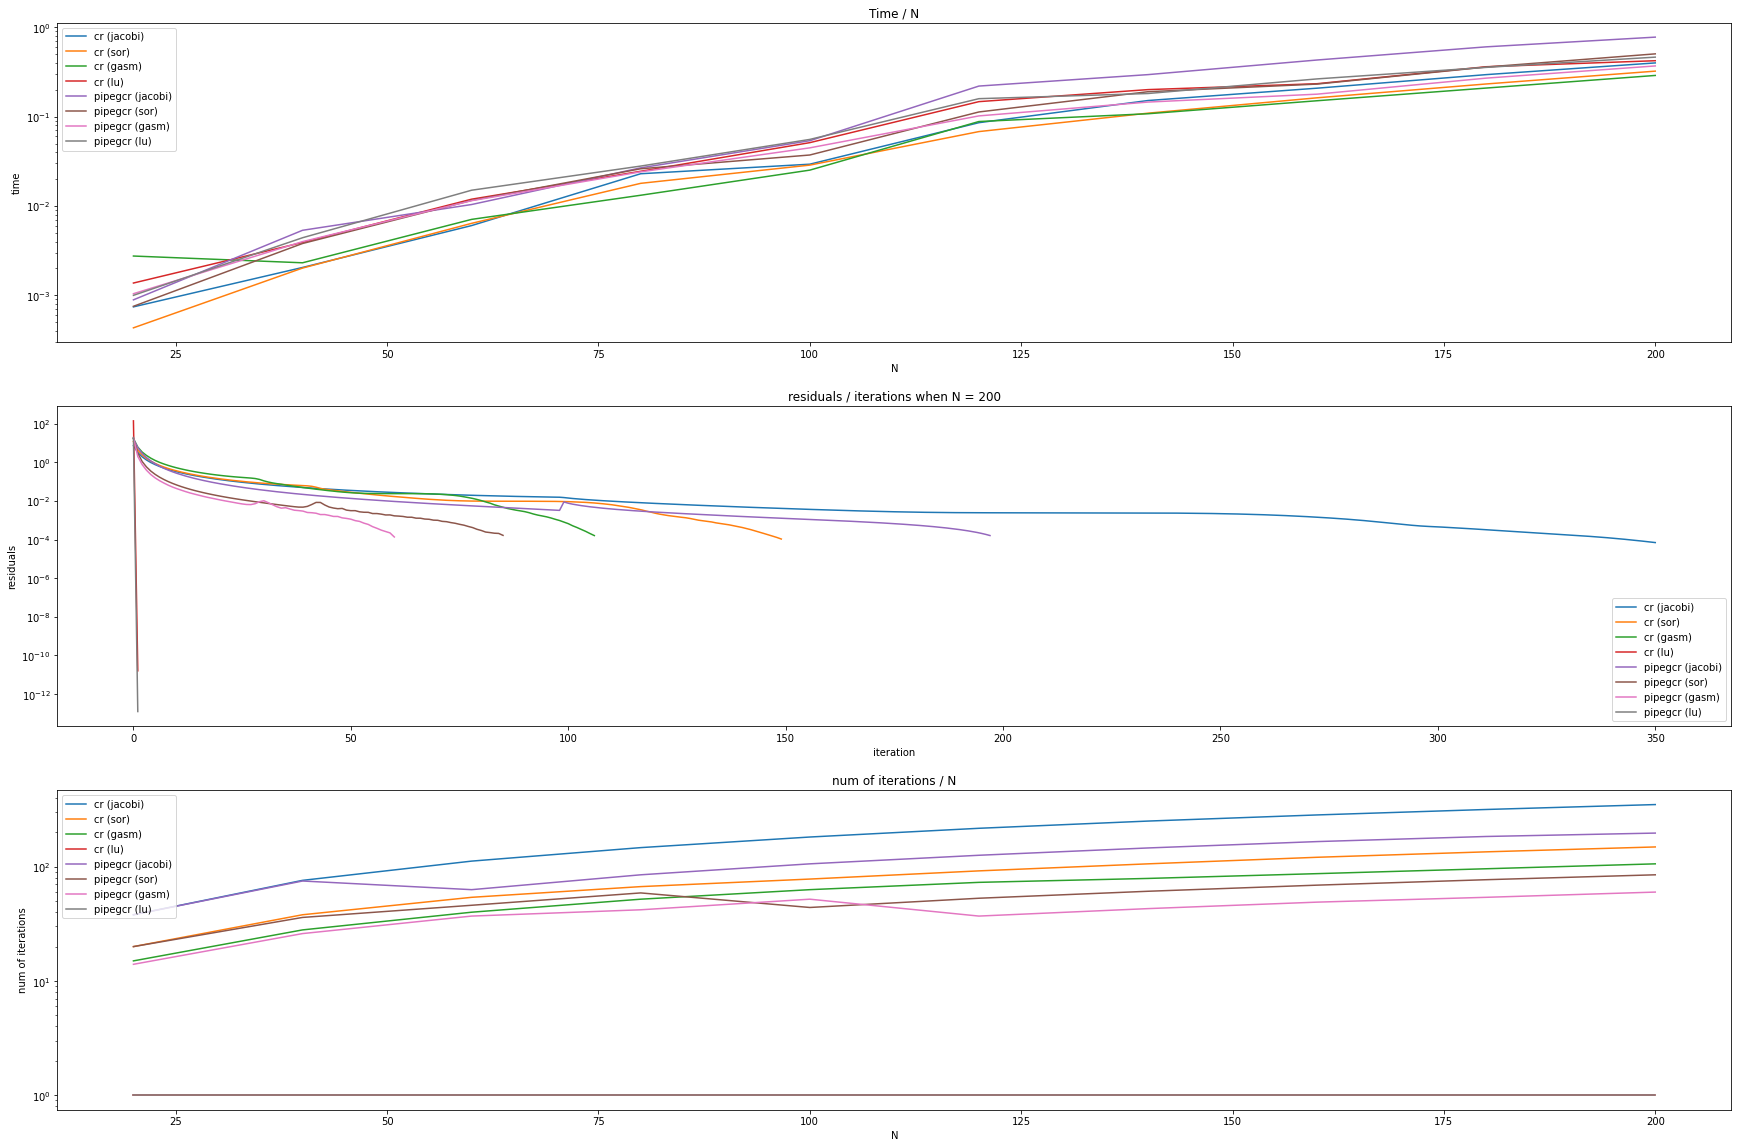

In [13]:
Ns = np.linspace(20, 200, 10, dtype=np.int32)


def test_PC():
    PET_solvers = []

    for name in ['cr', 'pipegcr']:
        for PC in ['jacobi', 'sor', 'gasm', 'lu']:
            solver = Solver(name)
            solver.PC = PC
            PET_solvers += [solver]

    for N in tqdm(Ns):
        A = generate_A(N)
        b = generate_b(N)

        iterate_pet_solvers(PET_solvers, A, b)

    fig = plt.figure(figsize=(30, 20))

    plt.subplot(3, 1, 1)
    ps = []
    for i, sv in enumerate(PET_solvers):
        p0, = plt.semilogy(Ns, sv.times)
        ps += [p0]

    plt.legend(ps, ['{} ({})'.format(sv.name, sv.PC) for sv in PET_solvers], loc='upper left')
    plt.title('Time / N')
    plt.ylabel('time')
    plt.xlabel('N')

    plt.subplot(3, 1, 2)
    ps = []
    for i, sv in enumerate(PET_solvers):
        p0, = plt.semilogy(sv.residuals[-1])
        ps += [p0]

    plt.legend(ps, ['{} ({})'.format(sv.name, sv.PC) for sv in PET_solvers], loc='lower right')
    plt.title('residuals / iterations when N = {}'.format(Ns[-1]))
    plt.ylabel("residuals")
    plt.xlabel('iteration')

    plt.subplot(3, 1, 3)
    ps = []
    for i, sv in enumerate(PET_solvers):
        p0, = plt.semilogy(Ns, sv.iterations)
        ps += [p0]

    plt.legend(ps, ['{} ({})'.format(sv.name, sv.PC) for sv in PET_solvers], loc='upper left')
    plt.title('num of iterations / N')
    plt.ylabel("num of iterations")
    plt.xlabel('N')

    plt.show()


test_PC()


* pick a solver (and a preconditioner if it improves the solver) that you think is most appropriate to solve this matrix-vector problem.

* Explain, making use of the data from your experiments, why this is the best solver for this problem.

## Part 4

* compute the solution to the matrix-vector problem.

* Measure the **time** taken to compute this solution, and compute the **error** of the solution. Make plots showing the time taken and error as $N$ is increased.

  0%|          | 0/45 [00:00<?, ?it/s]

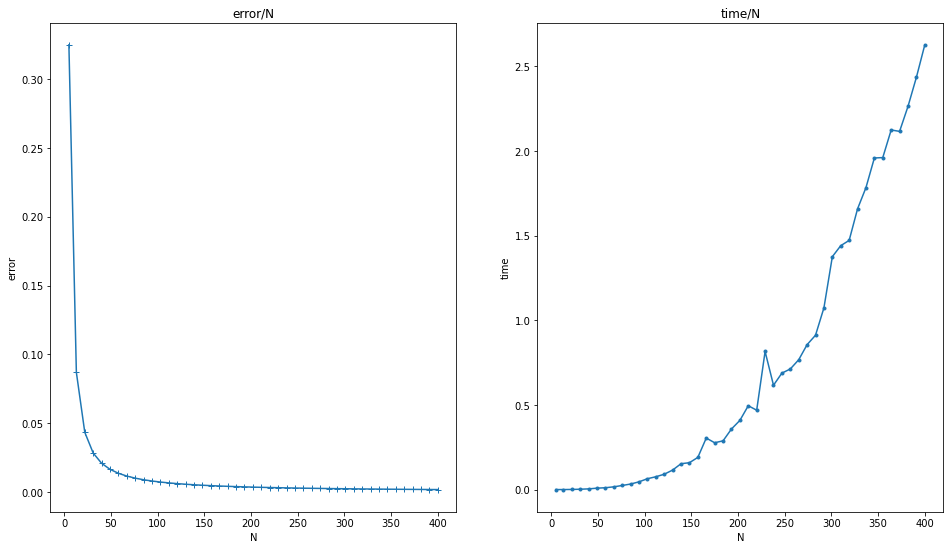

In [15]:
Ns = np.linspace(5, 400, 45, dtype=np.int32)

solver = Solver('pipegcr')
solver.PC = 'lu'

for N in tqdm(Ns):
    A = generate_A(N)
    b = generate_b(N)

    AA, bb = prepare_PET_data(A, b)

    solver.solve(AA, bb, count_time=True, save_residuals=False, save_iterations=False, save_solutions=True,
                 save_errors=True)


fig = plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
p0, = plt.plot(Ns, solver.errors, '+-')
plt.ylabel('error')
plt.title('error/N')
plt.xlabel('N')
plt.subplot(1, 2, 2)
p1, = plt.plot(Ns, solver.times, '.-')
plt.title('time/N')
plt.ylabel('time')
plt.xlabel('N')

plt.show()


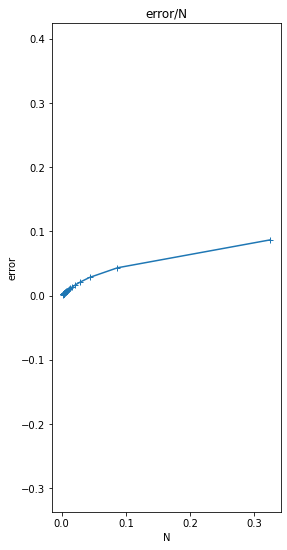

In [20]:
fig = plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
p0, = plt.plot(np.array(solver.errors[:-1]), solver.errors[1:], '+-')
plt.axis('equal')
plt.ylabel('error')
plt.title('error/N')
plt.xlabel('N')


plt.show()

 
 * estimate the **complexity** of the solver you are using
 
 * estimate the order of **convergence** of your solution

 * comment on how you have made these estimates of the complexity and order.

* Complexity: $O(N^2)$